In [1]:
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/opt/spark')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

In [2]:
# Let's read in the data. If you open the dataset, you'll find that each column has a header. We specify that by stating that header=True.
# To make our lives easier, we can also use 'inferSchema' when importing CSVs. This automatically detects data types.
# If you would like to manually change data types, refer to this article: https://medium.com/@mrpowers/adding-structtype-columns-to-spark-dataframes-b44125409803
df = spark.read.csv('Datasets/',header=True,inferSchema=True)

In [3]:
df = df.na.drop()

# df = df.na.drop(subset="road_surface_conditions")
# df = df.na.drop(subset="light_conditions")
# df = df.na.drop(subset="weather_conditions")
# df = df.na.drop(subset="accident_severity")
# df = df.na.drop(subset="day_of_week")

# df = df.na.drop(subset="special_conditions_at_site")
# df = df.na.drop(subset="pedestrian_movement")
df = df.na.drop(subset="age_of_vehicle")
df = df.na.drop(subset="sex_of_driver")
df = df.na.drop(subset="age_of_driver")
df = df.na.drop(subset="junction_location")
df = df.na.drop(subset="junction_detail")
df = df.na.drop(subset="junction_control")
df = df.na.drop(subset="day_of_week")
df = df.na.drop(subset="accident_severity")



print("Total data points2:", df.count())

Total data points2: 285331


In [4]:
features = [
          'age_of_vehicle','sex_of_driver','age_of_driver','junction_location','junction_detail','junction_control','day_of_week','accident_severity']
# features_s = ['light_conditions','weather_conditions']


df1 = df.select(*features)
df1 = df1.filter(df1.accident_severity > 1)
df1 = df1.filter(df1.age_of_vehicle > 0)
df1 = df1.filter(df1.junction_control > 0)




In [5]:

df1.count()


118313

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
# categoricalColumns = ['road_surface_conditions','light_conditions','weather_conditions']

ageofvehicle_indexer = StringIndexer(inputCol='age_of_vehicle',outputCol='ageofvehicleIndexer')
sexofdriver_indexer = StringIndexer(inputCol='sex_of_driver',outputCol='sexofdriverIndexer')
ageofdriver_indexer = StringIndexer(inputCol='age_of_driver',outputCol='ageofdriverIndexer')
junctionlocation_indexer = StringIndexer(inputCol='junction_location',outputCol='junctionlocationIndexer')
junctiondetail_indexer = StringIndexer(inputCol='junction_detail',outputCol='junctiondetailIndexer')
junctioncontrol_indexer = StringIndexer(inputCol='junction_control',outputCol='junctioncontrolIndexer')
dayofweek_indexer = StringIndexer(inputCol='day_of_week',outputCol='dayofweekIndexer')


accidentSeverity_indexer = StringIndexer(inputCol='accident_severity',outputCol='label')


# road_surface_conditions_encoder = OneHotEncoder(inputCol='road_surface_conditions_indexer',outputCol='road_surface_conditionsVec')
ageofvehicle_encoder = OneHotEncoder(inputCol='ageofvehicleIndexer',outputCol='ageofvehicleVec')
sexofdriver_encoder = OneHotEncoder(inputCol='sexofdriverIndexer',outputCol='sexofdriverVec')
ageofdriver_encoder = OneHotEncoder(inputCol='ageofdriverIndexer',outputCol='ageofdriverVec')
junctionlocation_encoder = OneHotEncoder(inputCol='junctionlocationIndexer',outputCol='junctionlocationVec')
junctiondetail_encoder = OneHotEncoder(inputCol='junctiondetailIndexer',outputCol='junctiondetailVec')
junctioncontrol_encoder = OneHotEncoder(inputCol='junctioncontrolIndexer',outputCol='junctioncontrolVec')
dayofweek_encoder = OneHotEncoder(inputCol='dayofweekIndexer',outputCol='dayofweekVec')


# And finally, using vector assembler to turn all of these columns into one column (named features).
assembler = VectorAssembler(inputCols=['ageofvehicleVec','sexofdriverVec','ageofdriverVec','junctionlocationVec','junctiondetailVec','junctioncontrolVec','dayofweekVec'], outputCol="features")

In [7]:
from pyspark.ml import Pipeline

# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[ageofvehicle_indexer, sexofdriver_indexer, ageofdriver_indexer,junctionlocation_indexer,junctiondetail_indexer,junctioncontrol_indexer,dayofweek_indexer,
                            accidentSeverity_indexer,
                            ageofvehicle_encoder, sexofdriver_encoder,ageofdriver_encoder,junctionlocation_encoder,junctiondetail_encoder,junctioncontrol_encoder,dayofweek_encoder,
                            assembler])

# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline.fit(df1)

# Incorporate results into a new DataFrame.
pipe_df = pipeline_model.transform(df1)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('label', 'features')

In [8]:
from pyspark.ml.classification import LogisticRegression

# Split our data. Note that the new DataFrame is being used.
train_data, test_data = pipe_df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

# Instantiate the model.
lr_model = LogisticRegression(featuresCol='features',labelCol='label')

# Fit the model.
lr_model = lr_model.fit(train_data)

# And evaluate the model using the test data.
results = lr_model.transform(test_data)

Training Dataset Count: 82860
Test Dataset Count: 35453


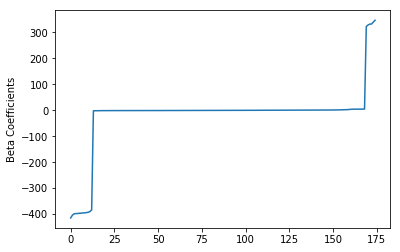

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Visualising the coefficients. Sort from lowest to highest.
beta = np.sort(lr_model.coefficients)

# Plot the data.
plt.plot(beta)

# Add a label to the data.
plt.ylabel('Beta Coefficients')

# Show the graph. 
plt.show()

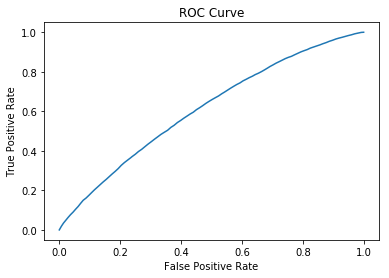

Area Under the Curve: 0.6118524985605542


In [11]:
# Let's get a summary of the data.
training_summary = lr_model.summary

# Convert the DataFrame to a Pandas DataFrame.
ROC = training_summary.roc.toPandas()

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

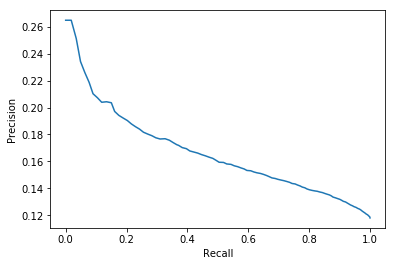

In [12]:
pr = training_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [13]:
predictions = lr_model.transform(test_data)
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(175,[0,64,67,149...|[2.57167044839752...|[0.92901593316079...|       0.0|
|  0.0|(175,[0,64,67,149...|[2.57167044839752...|[0.92901593316079...|       0.0|
|  0.0|(175,[0,64,67,149...|[2.57167044839752...|[0.92901593316079...|       0.0|
|  0.0|(175,[0,64,67,149...|[2.62995333194448...|[0.93276462269436...|       0.0|
|  0.0|(175,[0,64,67,149...|[2.62995333194448...|[0.93276462269436...|       0.0|
|  0.0|(175,[0,64,67,149...|[2.62995333194448...|[0.93276462269436...|       0.0|
|  0.0|(175,[0,64,67,149...|[2.62995333194448...|[0.93276462269436...|       0.0|
|  0.0|(175,[0,64,67,149...|[2.62995333194448...|[0.93276462269436...|       0.0|
|  0.0|(175,[0,64,67,149...|[2.58442158476659...|[0.92985222482989...|       0.0|
|  0.0|(175,[0,6

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.5969421958332293
